In [89]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from wordcloud import WordCloud

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import contractions

# 1. Exploration du jeu de données

In [87]:
DATASET_FILE = "./dataset.csv"

In [88]:
dataset_df = pd.read_csv(DATASET_FILE)
dataset_df

,text,stars
0,I've only had food from here once and it wasn'...,1
1,I will never return here again. Ever. I was ...,1
2,I wish my experience was great as others. I di...,1
3,Are the rosemary grapefruit scones supposed to...,1
4,Our takeout order was half wrong. Food was mis...,1
...,...,...
24995,I was a loyal fan of Aroy before the ownership...,5
24996,Stopped here for a bite while wandering around...,5
24997,"A quiet place with excellent food, great music...",5
24998,Super delicious food. Awesome vibe. I suffered...,5


## 1.1 Répartition des avis clients en fonction du nombre d'étoiles

In [ ]:
stars_columns = dataset_df.stars
stars_columns

0        1
1        1
2        1
3        1
4        1
        ..
24995    5
24996    5
24997    5
24998    5
24999    5
Name: stars, Length: 25000, dtype: int64

In [ ]:
dataset_df.stars.unique()

array([1, 2, 3, 4, 5], dtype=int64)

In [ ]:
stars_columns.value_counts()

1    5000
2    5000
3    5000
4    5000
5    5000
Name: stars, dtype: int64

<AxesSubplot:ylabel='stars'>

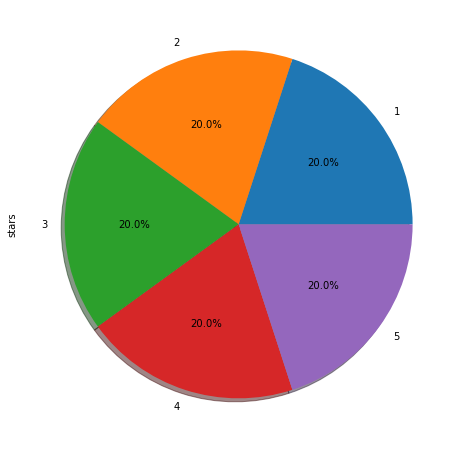

In [ ]:
stars_columns.value_counts().plot(kind="pie", figsize=(10, 8), autopct="%1.1f%%", shadow=True)

## 1.2 Distribution de la longueur (nombre de mots) des avis clients

In [ ]:
dataset_df["length"] = dataset_df["text"].apply(lambda x: len(x.split()))
dataset_df

,text,stars,length
0,I've only had food from here once and it wasn'...,1,68
1,I will never return here again. Ever. I was ...,1,87
2,I wish my experience was great as others. I di...,1,166
3,Are the rosemary grapefruit scones supposed to...,1,81
4,Our takeout order was half wrong. Food was mis...,1,32
...,...,...,...
24995,I was a loyal fan of Aroy before the ownership...,5,75
24996,Stopped here for a bite while wandering around...,5,55
24997,"A quiet place with excellent food, great music...",5,32
24998,Super delicious food. Awesome vibe. I suffered...,5,41


<AxesSubplot:ylabel='Frequency'>

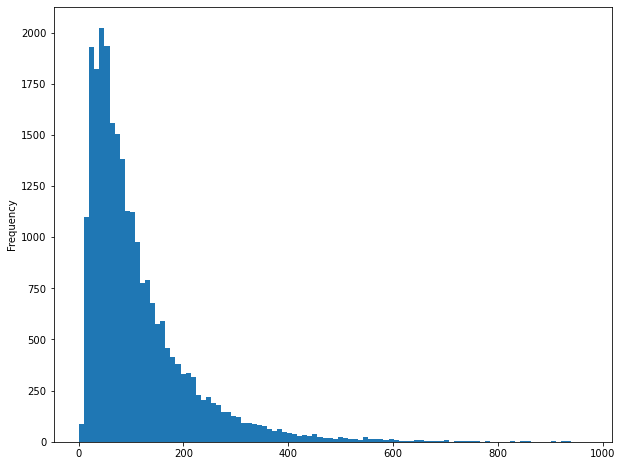

In [ ]:
dataset_df.length.plot(kind="hist", bins=100, figsize=(10, 8))

## 1.3 Distribution de la longueur des avis clients en fonction du nombre d'étoiles des avis

Text(0.5, 1.0, "Répartition des longueurs des avis en fonction du nombre d'étoiles")

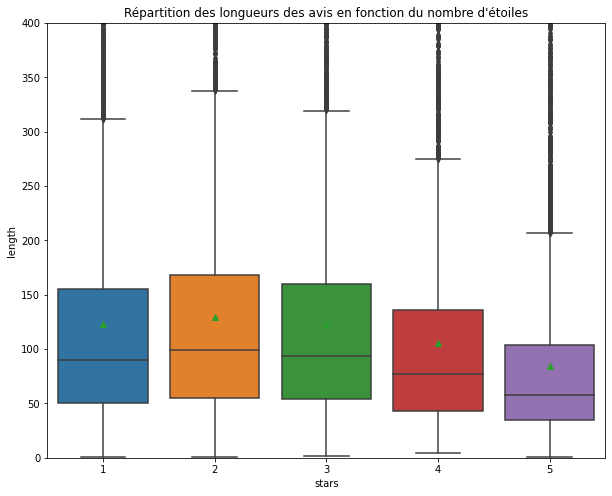

In [ ]:
plt.figure(figsize=(10, 8))

ax = sns.boxplot(x=dataset_df.stars ,
            y=dataset_df.length,
            showmeans=True,
            )
ax.set_ylim(0, 400)

ax.set_title("Répartition des longueurs des avis en fonction du nombre d'étoiles")

# 2. Pré-traitement du jeu de données

In [ ]:
text_ligne= dataset_df.text
text_ligne

0        I've only had food from here once and it wasn'...
1        I will never return here again.  Ever.  I was ...
2        I wish my experience was great as others. I di...
3        Are the rosemary grapefruit scones supposed to...
4        Our takeout order was half wrong. Food was mis...
                               ...                        
24995    I was a loyal fan of Aroy before the ownership...
24996    Stopped here for a bite while wandering around...
24997    A quiet place with excellent food, great music...
24998    Super delicious food. Awesome vibe. I suffered...
24999    I have a lot of dietary restrictions and this ...
Name: text, Length: 25000, dtype: object

## faire la contraction

In [90]:
#z=contractions.fix(dataset_df.text[i])
for i in range(len(dataset_df)): 
    z=contractions.fix(dataset_df.text[i])
    #print(z)
    dataset_df.text[i] = z


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [91]:
dataset_df

,text,stars
0,I have only had food from here once and it was...,1
1,I will never return here again. Ever. I was ...,1
2,I wish my experience was great as others. I di...,1
3,Are the rosemary grapefruit scones supposed to...,1
4,Our takeout order was half wrong. Food was mis...,1
...,...,...
24995,I was a loyal fan of Aroy before the ownership...,5
24996,Stopped here for a bite while wandering around...,5
24997,"A quiet place with excellent food, great music...",5
24998,Super delicious food. Awesome vibe. I suffered...,5


## ajouter _neg au mot negative

In [92]:
def tag_words(sentence):
    import re
    # up to punctuation as in punct, put tags for words
    # following a negative word
    # find punctuation in the sentence
    punct = re.findall(r'[.:;!?]',sentence)[0]
    # create word set from sentence
    wordSet = { x for x in re.split("[.:;!?, ]",sentence) if x }
    keywordSet = {"never", "nothing", "nowhere", "noone", "none", "not"}
   
    # find negative words in sentence
    neg_words = wordSet & keywordSet
    if neg_words:
        for word in neg_words:
            start_to_w = sentence[:sentence.find(word)+len(word)]
            # put tags to words after the negative word
            w_to_punct =  re.sub(r'\b([A-Za-z\']+)\b',r'\1_not',
                               sentence[sentence.find(word)+len(word):sentence.find(punct)])
            punct_to_end = sentence[sentence.find(punct):]
            return(start_to_w + w_to_punct + punct_to_end)
    else :
        return sentence

In [93]:
import re
def txt_conversion(sentence):
    #Getting only the letters from the tweets
    sentence=re.sub(r'[^a-zA-Z ]','',sentence)
    #Converting them to lowercase
    sentence=sentence.lower()
    #split based on space to remove multiple spaces
    words=sentence.split()
    #combining to form sentence
    return (" ".join(words)).strip()

In [94]:
dataset_df['text']=dataset_df['text'].apply(lambda x: txt_conversion(x))

In [95]:
dataset_df

,text,stars
0,i have only had food from here once and it was...,1
1,i will never return here again ever i was sitt...,1
2,i wish my experience was great as others i din...,1
3,are the rosemary grapefruit scones supposed to...,1
4,our takeout order was half wrong food was miss...,1
...,...,...
24995,i was a loyal fan of aroy before the ownership...,5
24996,stopped here for a bite while wandering around...,5
24997,a quiet place with excellent food great music ...,5
24998,super delicious food awesome vibe i suffered t...,5


In [96]:
for i in range(len(dataset_df)): 
    #dataset_df.reset_index(inplace=True, drop=True)
    x=tag_words(dataset_df.text[i])
    print(x)
    dataset_df.text[i] = x
    

IndexError: ignored

# lemmat + stopwords

In [97]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('omw-1.4')
def stop_wrds_lemma_convert(sentence):
    stop_words=nltk.corpus.stopwords.words('english')
    
    lemmatizer=WordNetLemmatizer()


    tokens = [w for w in sentence.split() if not w in stop_words] #stopwords removal
    newString=''
    for i in tokens:                                                 
        newString=newString+lemmatizer.lemmatize(i)+' '    #converting words to lemma                               
    return newString.strip() 

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## faire la tokenization

In [98]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [100]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [101]:
dataset_df['text']=dataset_df['text'].apply(lambda x: stop_wrds_lemma_convert(x))


In [105]:
from nltk.tokenize import word_tokenize

for i in range(len(dataset_df)): 
    x=word_tokenize(dataset_df.text[i])
    print(x)
    dataset_df.text[i]=x


['food', 'memorable', 'panang', 'curry', 'balance', 'flavor', 'like', 'taste', 'coconut', 'lemongrass', 'lime', 'lacking', 'east', 'asia', 'offering', 'way', 'sweet', 'care', 'owner', 'thai', 'eat', 'anything', 'cooked', 'well', 'place', 'claim', 'serve', 'thai', 'food']
['never', 'return', 'ever', 'sitting', 'booth', 'waiting', 'dinner', 'come', 'scurried', 'mouse', 'booth', 'dining', 'room', 'immediately', 'getting', 'leave', 'informed', 'front', 'desk', 'issue', 'blew', 'nothing', 'said', 'oh', 'ya', 'mouse', 'problem', 'big', 'deal', 'certainly', 'reporting', 'department', 'health', 'disgusting']
['wish', 'experience', 'great', 'others', 'dined', 'wednesday', 'night', 'week', 'ago', 'say', 'least', 'meal', 'horrible', 'jerk', 'chicken', 'entree', 'date', 'seafood', 'coconut', 'entree', 'presentation', 'nice', 'seafood', 'coconut', 'however', 'date', 'displeased', 'literally', 'bite', 'food', 'couple', 'bite', 'mine', 'mess', 'jerk', 'chicken', 'could', 'finish', 'also', 'expecting'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
['great', 'setting', 'great', 'restaurantthe', 'wait', 'staff', 'hostess', 'make', 'feel', 'like', 'family', 'always', 'personablethe', 'menu', 'tasty', 'adult', 'beverage', 'quench', 'hardiest', 'thirst']
['company', 'like', 'waiter', 'go', 'alias', 'chad', 'solid', 'maybe', 'even', 'feeling', 'generous', 'lower', 'standard', 'making', 'experience', 'full', 'cheer']
['delicious', 'went', 'happy', 'hour', 'ordered', 'mojitos', 'based', 'waiter', 'recommendation', 'amazing', 'food', 'excellent', 'well', 'prepared', 'attention', 'detail', 'flavor', 'restaurant', 'cute', 'decorated', 'well', 'waiterhost', 'funny', 'sweet', 'also', 'well', 'educated', 'menu']
['fresh', 'healthy', 'delicious', 'authentic', 'different', 'superb', 'service', 'nice', 'decor', 'great', 'experience']
['food', 'really', 'good', 'burger', 'juicy', 'bun', 'buttery', 'staff', 'really', 'helpful', 'well']
['lambert', 'great', 'grabbing', 'q

In [106]:
dataset_df

,text,stars
0,"[food, memorable, panang, curry, balance, flav...",1
1,"[never, return, ever, sitting, booth, waiting,...",1
2,"[wish, experience, great, others, dined, wedne...",1
3,"[rosemary, grapefruit, scone, supposed, taste,...",1
4,"[takeout, order, half, wrong, food, missing, p...",1
...,...,...
24995,"[loyal, fan, aroy, ownership, change, apprehen...",5
24996,"[stopped, bite, wandering, around, faneuil, ha...",5
24997,"[quiet, place, excellent, food, great, music, ...",5
24998,"[super, delicious, food, awesome, vibe, suffer...",5


In [108]:
dataset_df

,text,stars
0,"[food, memorable, panang, curry, balance, flav...",1
1,"[never, return, ever, sitting, booth, waiting,...",1
2,"[wish, experience, great, others, dined, wedne...",1
3,"[rosemary, grapefruit, scone, supposed, taste,...",1
4,"[takeout, order, half, wrong, food, missing, p...",1
...,...,...
24995,"[loyal, fan, aroy, ownership, change, apprehen...",5
24996,"[stopped, bite, wandering, around, faneuil, ha...",5
24997,"[quiet, place, excellent, food, great, music, ...",5
24998,"[super, delicious, food, awesome, vibe, suffer...",5


In [110]:
DATASET_FILE = "./dataclean.csv"

In [111]:
data = pd.read_csv(DATASET_FILE)

In [114]:
data=data.drop(['Unnamed: 0'],axis=1)

In [115]:
data

,text,stars
0,"['food', 'memorablenot', 'panang', 'curry', 'b...",1
1,"['never', 'returnnot', 'herenot', 'againnot', ...",1
2,"['wish', 'experience', 'great', 'others', 'din...",1
3,"['rosemary', 'grapefruit', 'scone', 'supposed'...",1
4,"['takeout', 'order', 'half', 'wrong', 'food', ...",1
...,...,...
24995,"['loyal', 'fan', 'aroy', 'ownership', 'change'...",5
24996,"['stopped', 'bite', 'wandering', 'around', 'fa...",5
24997,"['quiet', 'place', 'excellent', 'food', 'great...",5
24998,"['super', 'delicious', 'food', 'awesome', 'vib...",5


In [124]:
classification= {"stars":{1:0,2:0,3:1,4:1,5:1}}

In [125]:
data.replace(classification,inplace=True)
data

,text,stars
0,"['food', 'memorablenot', 'panang', 'curry', 'b...",0
1,"['never', 'returnnot', 'herenot', 'againnot', ...",0
2,"['wish', 'experience', 'great', 'others', 'din...",0
3,"['rosemary', 'grapefruit', 'scone', 'supposed'...",0
4,"['takeout', 'order', 'half', 'wrong', 'food', ...",0
...,...,...
24995,"['loyal', 'fan', 'aroy', 'ownership', 'change'...",1
24996,"['stopped', 'bite', 'wandering', 'around', 'fa...",1
24997,"['quiet', 'place', 'excellent', 'food', 'great...",1
24998,"['super', 'delicious', 'food', 'awesome', 'vib...",1


In [126]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
#split data
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['stars'], test_size=0.2, random_state=42)
####Regression
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [127]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
x=data['text']
y=data['stars']
#Split Data et faire la matrice tfIdf
vectorizer = TfidfVectorizer()
X_train, X_test, y_train, y_test = train_test_split(vectorizer.fit_transform(x),y,train_size=0.8, test_size=0.2, random_state=0)
####Regression
clf = LogisticRegression()
clf.fit(X_train, y_train)
#Accuracy
pred=clf.predict(X_test)
print("Accuracy du modèle:",accuracy_score(pred,y_test))

Accuracy du modèle: 0.8632
